#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, regularizers
import matplotlib.colors as mcolors
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### loading and displaying the datasets

In [2]:
train=pd.read_csv('SQLIV3_cleaned2.csv')
test=pd.read_csv('sqliv2_utf8.csv')
print(train)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [3]:
train.Label.value_counts()


0    19268
1    11346
Name: Label, dtype: int64

#### 'Label' Data Distribution


Text(0.5, 1.0, 'Label')

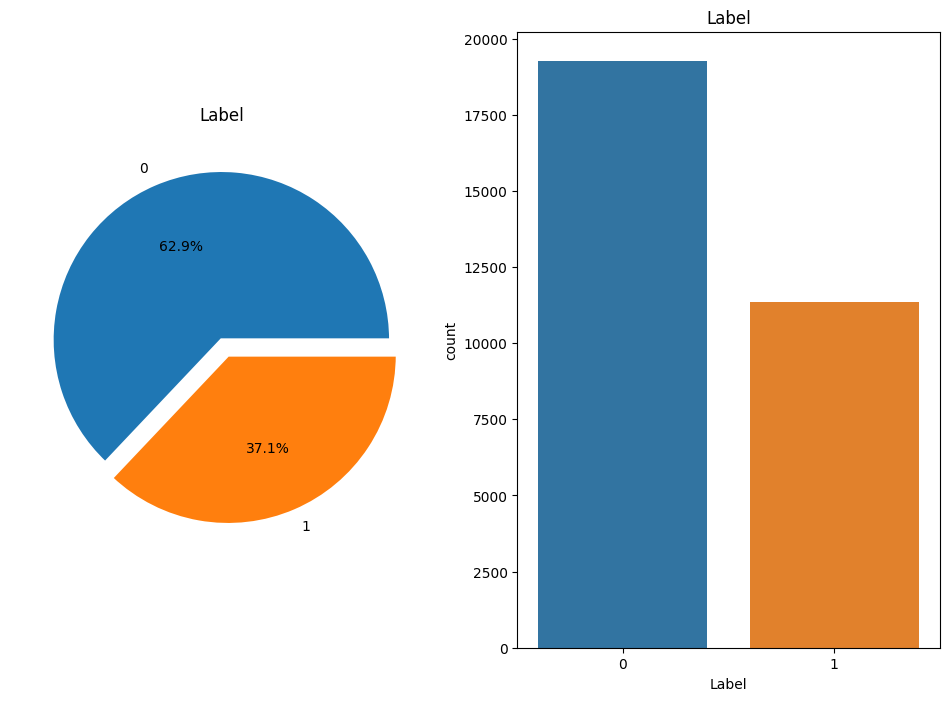

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train, ax=ax[1], palette=colors)
ax[1].set_title('Label')

#### Model Configuration

In [5]:
hidden_units1=512
hidden_units2=256
hidden_units3=128
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=27

In [6]:
model = Sequential()
model.add(Dense(hidden_units1, input_dim=3000, activation=hidden_layer_act))
model.add(Dense(hidden_units2, activation=hidden_layer_act))
model.add(Dense(hidden_units3, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))  # Couche de sortie

#### Compilation

In [7]:
sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [8]:
train_x = train['Sentence'].values
train_y = train['Label'].values

test_x = test['Sentence'].values
test_y = test['Label'].values

#### Text Vectorization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
train_x = vectorizer.fit_transform(train_x).toarray()


#### Model training

In [10]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

In [11]:
history = model.fit(train_x, train_y, epochs=no_epochs, batch_size=32, verbose=2, validation_split=0.2,callbacks=[early_stop])


Epoch 1/27
766/766 - 9s - loss: 0.6723 - accuracy: 0.6069 - val_loss: 0.6418 - val_accuracy: 1.0000
Epoch 2/27
766/766 - 8s - loss: 0.5907 - accuracy: 0.8490 - val_loss: 0.5807 - val_accuracy: 0.9430
Epoch 3/27
766/766 - 11s - loss: 0.3187 - accuracy: 0.9308 - val_loss: 0.2772 - val_accuracy: 0.9600
Epoch 4/27
766/766 - 15s - loss: 0.1486 - accuracy: 0.9538 - val_loss: 0.1971 - val_accuracy: 0.9528
Epoch 5/27
766/766 - 12s - loss: 0.1034 - accuracy: 0.9618 - val_loss: 0.0897 - val_accuracy: 0.9822
Epoch 6/27
766/766 - 16s - loss: 0.0818 - accuracy: 0.9711 - val_loss: 0.1141 - val_accuracy: 0.9683
Epoch 7/27
766/766 - 14s - loss: 0.0682 - accuracy: 0.9798 - val_loss: 0.0497 - val_accuracy: 0.9873
Epoch 8/27
766/766 - 13s - loss: 0.0591 - accuracy: 0.9852 - val_loss: 0.0521 - val_accuracy: 0.9838
Epoch 9/27
766/766 - 11s - loss: 0.0524 - accuracy: 0.9888 - val_loss: 0.0309 - val_accuracy: 0.9915
Epoch 10/27
766/766 - 8s - loss: 0.0477 - accuracy: 0.9905 - val_loss: 0.0399 - val_accuracy:

#### Final Training Metrics Display

In [12]:
# Affichage de la loss et accuracy après l'entraînement
print("Final Training Loss:", history.history['loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])



Final Training Loss: 0.04168682172894478
Final Training Accuracy: 0.9922828674316406


#### Plotting Loss and Accuracy over Epochs


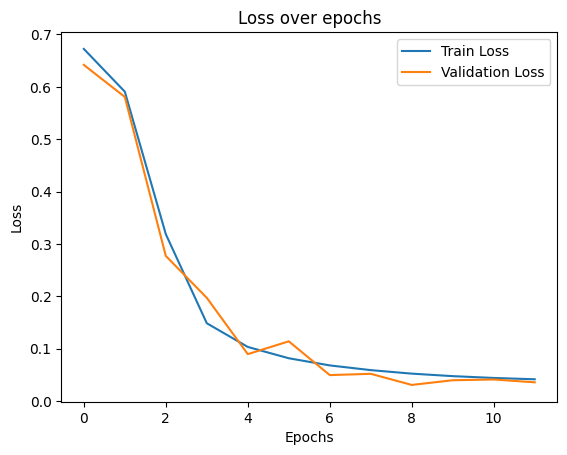

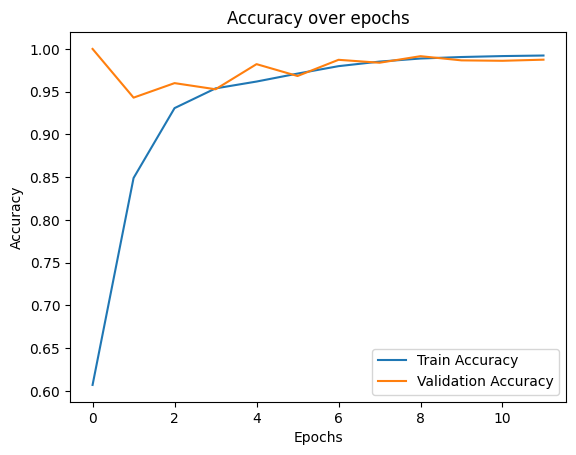

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
test_x = test['Sentence'].values
test_y = test['Label'].values
print(test.isnull().sum())


Sentence    3
Label       0
dtype: int64


In [15]:
test = test.dropna(subset=['Sentence'])



#### Filter Only SQL Injection (Label = 1)


In [16]:
# Filtrer les lignes où Label == 1
filtered = test[test['Label'] == 1]

# Supprimer les doublons en gardant la première occurrence
filtered = filtered.drop_duplicates(subset='Sentence', keep='first')

# Récupérer les 1000 exemples dans test_x et test_y
test_x = filtered['Sentence'].values
test_y = filtered['Label'].values

test_x = vectorizer.transform(test_x).toarray()


#### Prediction and Metrics Evaluation


In [17]:
predictions = model.predict(test_x)


In [18]:
# Convertir les probabilités en classes binaires
predicted_classes = (predictions >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes.flatten())


[1 1 1 ... 1 1 1]


In [19]:
# Compter le nombre de prédictions égales à 1
nombre_de_sql_injections = (predicted_classes == 1).sum()

print(f"Nombre de requêtes détectées comme SQL injection : {nombre_de_sql_injections}")


Nombre de requêtes détectées comme SQL injection : 11163


In [20]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print(f"Nombre de requêtes détectées comme SQL injection : {nombre_de_sql_injections} / {len(test_x)}")
print(f"Accuracy après test avec le dataset filtré (SQL injections) : {accuracy_score(test_y, predicted_classes) * 100:.2f}%")
print(f"Precision : {precision_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"Recall : {recall_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"F1 Score : {f1_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")


Nombre de requêtes détectées comme SQL injection : 11163 / 11424
Accuracy après test avec le dataset filtré (SQL injections) : 97.72%
Precision : 100.00%
Recall : 97.72%
F1 Score : 98.84%


#### Filter Only Normal Queries (Label = 0)


In [32]:

filtered2 = test[test['Label'] == 0]
filtered2 = filtered2.drop_duplicates(subset='Sentence', keep='first')


test_x2 = filtered2['Sentence'].values
test_y2 = filtered2['Label'].values


test_x2 = vectorizer.transform(test_x2).toarray()

#### Prediction and Metrics Evaluation


In [33]:
predictions2 = model.predict(test_x2)


In [34]:
# Convertir les probabilités en classes binaires
predicted_classes2 = (predictions2 >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes2.flatten())


[0 0 0 ... 0 0 0]


In [35]:

nombre_de_non_sql_injections = (predicted_classes2 == 0).sum()

print(f"Nombre de requêtes non détectées comme SQL injection : {nombre_de_non_sql_injections}")


Nombre de requêtes non détectées comme SQL injection : 22182


In [36]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [37]:
print(f"accuracy apres testé avec le deuxiéme datset avec les non sql injection est ={nombre_de_non_sql_injections/len(test_x2)} ")

accuracy apres testé avec le deuxiéme datset avec les non sql injection est =0.9945747208895664 


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print(f"Nombre de requêtes détectées comme NON SQL injection : {nombre_de_non_sql_injections} / {len(test_x2)}")

# Métriques adaptées à la classe 0
print(f"Accuracy : {accuracy_score(test_y2, predicted_classes2) * 100:.2f}%")
print(f"Precision (classe 0) : {precision_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"Recall (classe 0) : {recall_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"F1 Score (classe 0) : {f1_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")


Nombre de requêtes détectées comme NON SQL injection : 22182 / 22303
Accuracy : 99.46%
Precision (classe 0) : 100.00%
Recall (classe 0) : 99.46%
F1 Score (classe 0) : 99.73%
